In [1]:
%run setup.py

In [2]:
stars = pd.read_excel(rootpath+'surface/sample/samples.xlsx')
idx = (stars['ifmodelling']==1) & ((stars['e_lum_J']/stars['lum_J'])<0.3) & np.isfinite(stars['Teff']) & np.isfinite(stars['[M/H]']) & (~np.isin(stars['names'], ['ngc6819', 'ngc6791', 'binary']))

stars = stars.loc[idx,:].reset_index(drop=True)

# read in sample

In [3]:
suf = '_micp'
original_cols = ['star_mass', 'radius', 'Dnu_freq', 'Dnu_freq_o', 'surf_corr_at_numax', 'amlt', ]
to_append_cols = ['mass'+suf, 'radius'+suf, 'Dnu_freq'+suf, 'Dnu_freq_o'+suf, 'surf_corr'+suf, 'amlt'+suf, ]
to_append_e_cols = ['e_'+col for col in to_append_cols]

def multi(inputs):
    istar, star = inputs
    filepath = rootpath+'surface/results_spec_gaia_nu_sc/{:0.0f}/summary_prob.txt'.format(star['KIC'])
    if not os.path.exists(filepath): return [np.nan]*(len(to_append_cols)*2)

    data = ascii.read(filepath, delimiter=',')
    var = list(data[original_cols][1])
    e_var = list((np.array(list(data[original_cols][2])) - np.array(list(data[original_cols][0])))/2.)
    
    return var + e_var

r = process_map(multi, stars.iterrows(), total=len(stars), max_workers=12)

stars.loc[:, to_append_cols+to_append_e_cols]  = np.array(r)

  0%|          | 0/1222 [00:00<?, ?it/s]

In [4]:
sample = stars

# process model data

In [5]:
idx = sample['names']=='Sun'
(1-sample.loc[idx,'Dnu_freq_o_micp']/sample.loc[idx,'Dnu_freq_micp'])*100

50   -0.496751
dtype: float64

0

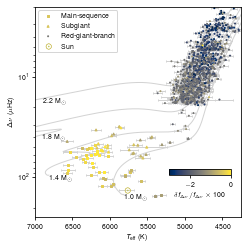

In [7]:
import matplotlib.colors
# norm = matplotlib.colors.LogNorm(vmin=0.2, vmax=4.)
norm = matplotlib.colors.Normalize(vmin=-3, vmax=0.)
cmap = 'cividis'

fig, axes = plt.subplots(figsize=mnras_size(ratio=1,column='one'), nrows=1, ncols=1, 
                         squeeze=False, constrained_layout=True)
axes = axes.reshape(-1)

msize, lw, mew, alpha = 4, 0.5, 0.5, 1.

sunstyle = {'marker':'$\\odot$', 's':msize+32, 'edgecolor':plt.cm.cividis(norm(-0.496751)), 'facecolor':'none', 'linewidths':0.4, 'label':'Sun', 'alpha':alpha, 'norm':norm}
rgstyle = {'marker':'.', 'cmap': cmap, 's':msize, 'label':'Red-giant-branch', 'alpha':alpha, 'norm':norm}
msstyle = {'marker':'s', 'cmap': cmap, 's':msize, 'label':'Main-sequence', 'alpha':alpha, 'norm':norm}
sgstyle = {'marker':'^', 'cmap': cmap, 's':msize, 'label':'Subgiant', 'alpha':alpha, 'norm':norm}

styles = {'marker':'.', 's':4, 'norm':norm, 'cmap':'cool'} #'c':blue, 
errorstyles = {'elinewidth':1, 'capsize':1, 'ecolor':'lightgray', 'linestyle':'None', 'zorder':-10}
estyles = {'linestyle':'-', 'color':'k', 'ecolor':'k', 'capsize':2, 'marker':'o', 'ms':4, 'zorder':10}

idx = np.isfinite(sample['mass_micp'])
rg = idx & np.isin(sample['stage'],['rgb','lsg'])
sg = idx & np.isin(sample['stage'],['esg', ])
sun = idx & np.isin(sample['names'],['Sun'])
ms = idx & np.isin(sample['stage'],['ms']) & (~sun)

# axes[0,0].scatter(stars.loc[idx,'Teff'], stars.loc[idx,'Dnu_freq_micp'], c=-stars.loc[idx,'surf_corr_micp'], **styles)

idxes = [ms, sg, rg, sun]
styles = [msstyle, sgstyle, rgstyle, sunstyle]
for i in range(4):
    styles[i]['c'] = (1-sample.loc[idxes[i],'Dnu_freq_o_micp']/sample.loc[idxes[i],'Dnu_freq_micp'])*100

    axes[0].scatter(sample.loc[idxes[i], 'Teff'],  sample.loc[idxes[i], 'Dnu'], rasterized=True, **styles[i])
    axes[0].errorbar(sample.loc[idxes[i], 'Teff'],  sample.loc[idxes[i], 'Dnu'], rasterized=True,
                    xerr = sample.loc[idxes[i], 'e_Teff'], yerr=sample.loc[idxes[i], 'e_Dnu'], 
                     **errorstyles)

for iax in range(1):
    axes[iax].axis([7000, 4250, 250., 2.])
    axes[iax].set_yscale('log')
    axes[iax].set_xlabel('$T_{\\rm{eff}}$  (K)')
    axes[iax].set_ylabel('$\\Delta\\nu$ ($\\mu$Hz)')
    axes[iax].legend(fontsize=fontsize)

    cax = axes[iax].inset_axes([0.65, 0.2, 0.3, 0.03], transform=axes[iax].transAxes)
    fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='horizontal').set_label('$\\delta f_{\\Delta\\nu}/f_{\\Delta\\nu}\\times100$')



# get tracks 
params = pd.read_csv(rootpath+'hpc/coarse_v2/template/coarse_grid_input_params_v2.txt', engine='python', sep=', ')
Zsun, Xsun = 0.0134, 0.7381
params['feh'] = np.log10(params['Zinit']/params['Xinit']) - np.log10(Zsun/Xsun)
masses = np.array([1.0, 1.4, 1.8, 2.2])
e_mass = 0.01
Yinit, e_Yinit = 0.290, 0.01
amlt, e_amlt = 1.7, 0.02
feh, e_feh = 0., 0.01

indexes = []
for mass in masses:
    metric = (params['star_mass']-mass)**2.0/e_mass**2.0 + \
    (params['Yinit']-Yinit)**2.0/e_Yinit**2.0 + \
    (params['amlt']-amlt)**2.0/e_amlt**2.0 + \
    (params['feh']-feh)**2.0/e_feh**2.0 
    indexes.append(np.argmin(metric))

indexes = [6167, 6891, 3897, 1093]

for i in indexes:
    data=h5py.File(rootpath+'hpc/coarse_v2/pre_rgb_tip/complete_grid/index{:06.0f}.history.h5'.format(i), 'r')
    
    for iax in range(1):
        idx = (data['phase'][:]>=0) & (10.0**(data['log_LHe'][:]-data['log_Lnuc'][:])<0.00001)
        axes[iax].plot(data['Teff'][idx], data['delta_nu'][idx], c='lightgray', linestyle='-', lw=1, zorder=-9)

        idx = idx & (data['Teff'][:]<6900)
        axes[iax].text(data['Teff'][idx][0], data['delta_nu'][idx][0]*1.1, '{:0.1f}'.format(data['star_mass'][idx][0])+' M$_{\\odot}$',)


filename = 'Fig.8_fDnu_HRD.pdf'

plt.savefig(filename)
os.system(to_overleaf(filename, 'figures'))

In [ ]:
# delta fdnu = fdnu_new - fdnu_old = Dnu_freq_new/density - Dnu_freq_old/density